# 导入依赖，初始化设备

In [160]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch version: 2.1.2
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


# 导入模拟数据集

In [161]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.01


X = torch.arange(start, end, step).unsqueeze(1)

y = weight * X + bias


# 分割数据集

In [162]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(y_train), len(X_test), len(y_test)


(80, 80, 20, 20)

# 数据可视化到2D图标

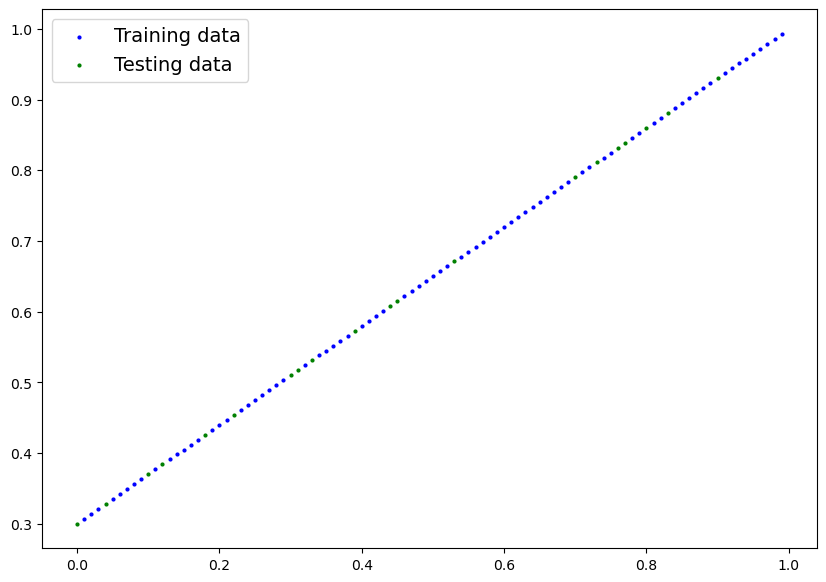

In [163]:
def plot_predictions(train_data, train_labels, test_data, test_labels, predictions=None):
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data.cpu(), train_labels.cpu(), c="b", s=4, label="Training data")
    plt.scatter(test_data.cpu(), test_labels.cpu(), c="g", s=4, label="Testing data")
    if predictions is not None:
        plt.scatter(test_data.cpu(), predictions.cpu(), c="r", s=4, label="Predictions")
    plt.legend(prop={"size": 14})

plot_predictions(X_train, y_train, X_test, y_test)

# 创建网络层

In [164]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x) -> torch.Tensor:
        return self.linear(x)

In [165]:
torch.manual_seed(42)
model_train = LinearRegression().to(device)

model_train.state_dict()

OrderedDict([('linear.weight', tensor([[0.7645]], device='mps:0')),
             ('linear.bias', tensor([0.8300], device='mps:0'))])

# 定义损失函数和优化器

In [166]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model_train.parameters(), lr=0.001)

# 训练模型

Epoch 0 | train loss: 0.3170473277568817 | test loss: 0.3109590709209442
Epoch 1000 | train loss: 0.003837293479591608 | test loss: 0.004645652137696743
Epoch 2000 | train loss: 0.001502519124187529 | test loss: 0.0016465140506625175
Epoch 3000 | train loss: 0.0011481422698125243 | test loss: 0.001221227110363543
Epoch 4000 | train loss: 0.0008840194786898792 | test loss: 0.0009376811212860048
Epoch 5000 | train loss: 0.0006806963356211782 | test loss: 0.000721838790923357
Epoch 6000 | train loss: 0.0005241362960077822 | test loss: 0.0005558037082664669
Epoch 7000 | train loss: 0.0004035872407257557 | test loss: 0.00042797112837433815
Epoch 8000 | train loss: 0.0003107681986875832 | test loss: 0.00032954299240373075
Epoch 9000 | train loss: 0.00023929285816848278 | test loss: 0.0002537502150516957
Epoch 10000 | train loss: 0.00018425808229949325 | test loss: 0.00019539087952580303
Epoch 11000 | train loss: 0.00014188085333444178 | test loss: 0.0001504517422290519
Epoch 12000 | train lo

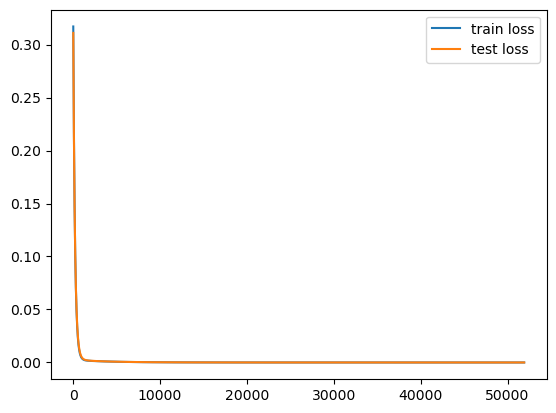

In [167]:
eopchs = 100000
train_losses, test_losses = [],[]
tolerance = 0

for epoch in range(eopchs):
    model_train.train()

    # 1.Forward pass
    y_pred = model_train(X_train.to(device))

    # 2.Compute loss
    loss = loss_fn(y_pred, y_train.to(device))

    # 3.Zero gradients
    optimizer.zero_grad()

    # 4.Backward pass
    loss.backward()

    train_losses.append(loss.item())

    # 5.Update the weights
    optimizer.step()

    model_train.eval()
    with torch.inference_mode():
        y_test_pred = model_train(X_test.to(device))

        loss_test = loss_fn(y_test_pred, y_test.to(device))

        test_losses.append(loss_test.item())

        if loss_test.item() == test_losses[epoch-1]:
            tolerance += 1
        else:
            tolerance = 0

        if tolerance == 1000:
            print(f"Model early stopped at epoch {epoch} | train loss: {loss.item()} | test loss: {loss_test.item()}")
            break

    if epoch % 1000 == 0:
        print(f"Epoch {epoch} | train loss: {loss.item()} | test loss: {loss_test.item()}")

plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()



In [168]:
model_train.state_dict()

OrderedDict([('linear.weight', tensor([[0.6998]], device='mps:0')),
             ('linear.bias', tensor([0.3001], device='mps:0'))])

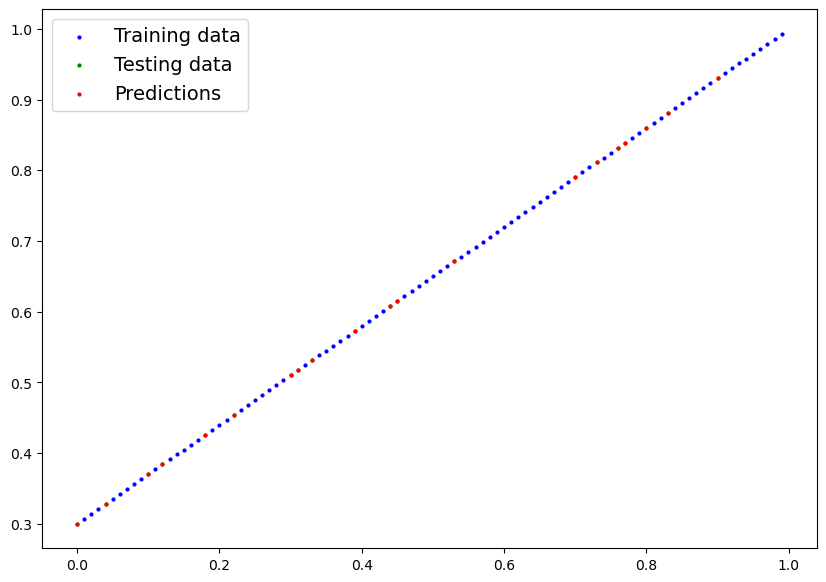

In [169]:
model_train.eval()
with torch.inference_mode():
    y_pred = model_train(X_test.to(device))

plot_predictions(X_train, y_train, X_test, y_test, y_pred)

# 保存模型

In [170]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "linear_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(model_train.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

Model saved to models/linear_model.pth


# 读取模型

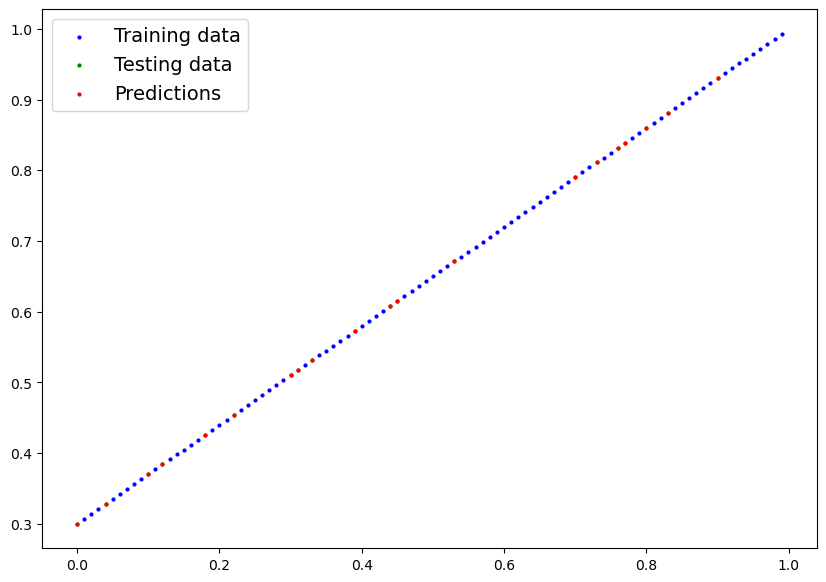

In [173]:
model_loaded = LinearRegression().to(device)

model_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))

model_loaded.eval()
with torch.inference_mode():
    y_pred_loaded = model_loaded(X_test.to(device))

plot_predictions(X_train, y_train, X_test, y_test, y_pred_loaded)